# Dataset
Our dataset, obtained from kaggle, contains a metadata-rich collection of conversations extracted from raw movie scripts. We are talking about 220,579 conversational exchanges between 10,292 pairs of movie characters involving 9,035 characters from 617 movies. This totals 304,713 utterances. 
In our project, we will be using the following files from the dataset: movie_lines.tsv, movie_conversations.tsv, movie_characters_metadata.tsv, movie_titles_metadata.tsv.

# Data Exploratory Analysis
Starting by eliminating duplicates

In [2]:
import pandas as pd
import sqlite3

dbfile = 'final.db'
con = sqlite3.connect(dbfile)
cursor = con.cursor()

# Read the data into a DataFrame
df_lines = pd.read_sql_query("SELECT * from line", con)
df_movies = pd.read_sql_query("SELECT * from movie", con)
df_characters = pd.read_sql_query("SELECT * from character", con)
df_conversations = pd.read_sql_query("SELECT * from conversation", con)
df_genres = pd.read_sql_query("SELECT * from genre", con)
df_movie_genre = pd.read_sql_query("SELECT * from movie_genre", con)

# check how many rows and columns in each df
print(df_lines.shape)
print(df_movies.shape)
print(df_characters.shape)
print(df_conversations.shape)
print(df_genres.shape)
print(df_movie_genre.shape)

# remove duplicates for every df
df_lines.drop_duplicates(inplace=True)
df_movies.drop_duplicates(inplace=True)
df_characters.drop_duplicates(inplace=True)
df_conversations.drop_duplicates(inplace=True)
df_genres.drop_duplicates(inplace=True)
df_movie_genre.drop_duplicates(inplace=True)

# check how many rows and columns in each df
print(df_lines.shape)
print(df_movies.shape)
print(df_characters.shape)
print(df_conversations.shape)
print(df_genres.shape)
print(df_movie_genre.shape)



(304413, 5)
(617, 5)
(9033, 6)
(83054, 4)
(24, 2)
(1825, 2)
(304413, 5)
(617, 5)
(9033, 6)
(83054, 4)
(24, 2)
(1825, 2)


We can see that there is no duplicate data in the dataset.
## Dealing with missing data

In [3]:
# check how many null values in each df
print('Lines missing values: ', df_lines.isnull().sum())
print('Movies missing values: ', df_movies.isnull().sum())
print('Characters missing values: ', df_characters.isnull().sum())
print('Conversations missing values: ', df_conversations.isnull().sum())
print('Genres missing values: ', df_genres.isnull().sum())
print('Movie genre missing values: ', df_movie_genre.isnull().sum())



Lines missing values:  id                 0
character_id       0
movie_id           0
line_text          0
conversation_id    0
dtype: int64
Movies missing values:  id             0
title          0
year           0
imdb_rating    0
imdb_votes     0
dtype: int64
Characters missing values:  id               0
name             0
movie_id         1
gender        6018
credit_pos    6354
actor_id      2846
dtype: int64
Conversations missing values:  id                0
first_char_id     0
second_char_id    0
movie_id          0
dtype: int64
Genres missing values:  id      0
name    0
dtype: int64
Movie genre missing values:  movie_id    0
genre_id    0
dtype: int64


We can see that the 'Characters' table has a lot of missing values for the 'gender' column. 

Also, there are 2846 characters which the actor name is unknown. 

## Visualizing the data
Considering that this is a movie dataset, maybe it will be interesting to know the distribution of the IMDb rating of the movies in order to validate the quality of the dataset. Normally, the movies with the highest ratings are the ones that are most popular and have the most lines of dialogue.\
We can see that most of the movies have a rating higher than 6. In fact, in IMDb if the rating's above 7.5, it's safe to say that it's generally known as a good movie. So, we can say that the dataset is good enough to work with.

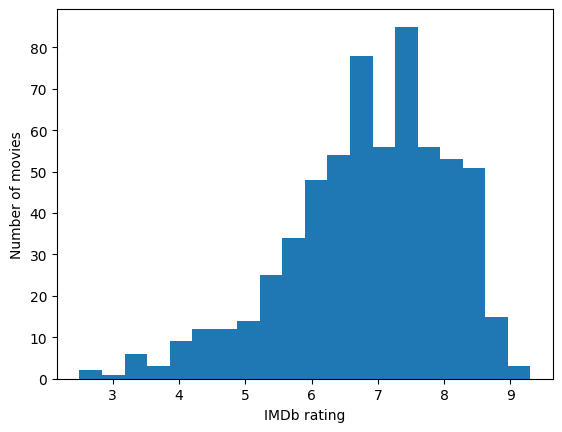

In [4]:
import matplotlib.pyplot as plt
plt.hist(df_movies['imdb_rating'], bins=20)
plt.ylabel('Number of movies')
plt.xlabel('IMDb rating')
plt.show()

However, if a movie has only 1 vote and it's 10, it doesn't mean that it's a good movie. So, we must check the distribution of the number of votes for each movie. The way we are going to do this is by plotting a pie chart where we group the movies by:
* 0-100 votes
* 100-1000 votes
* more than 1000 votes

We can see that the majority of the movies have more than 1000 votes, which provides us a good insight about the quality of the dataset.

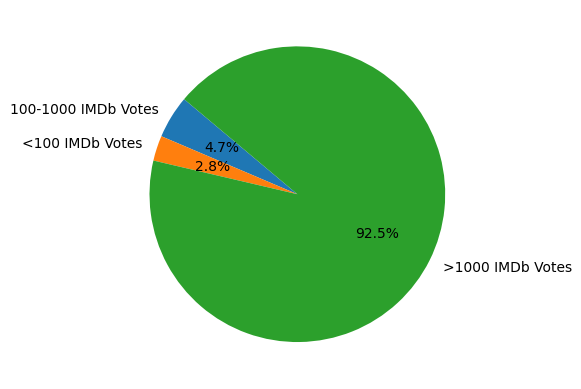

In [27]:
query = """
    SELECT
    CASE
        WHEN imdb_votes < 100 THEN '<100 IMDb Votes'
        WHEN imdb_votes >= 100 AND imdb_votes <= 1000 THEN '100-1000 IMDb Votes'
        ELSE '>1000 IMDb Votes'
    END AS vote_category,
    COUNT(*) AS movie_count
FROM movie
GROUP BY vote_category
ORDER BY vote_category;
"""

cursor.execute(query)
results = cursor.fetchall()

categories = [result[0] for result in results]
counts = [result[1] for result in results]

plt.pie(counts, labels=categories, autopct='%1.1f%%',startangle=140)
plt.show()

Let's see if there is any relation between the IMDb rating and the number of lines of dialogue. We are going to plot a scatter plot where the x-axis is the number of lines of dialogue and the y-axis is the IMDb rating.\
As we can see, there doesn't appear to be any correlation between the number of lines of dialogue and the IMDb rating. This is a good thing because it means that the dataset is not biased towards the movies with the most lines of dialogue.

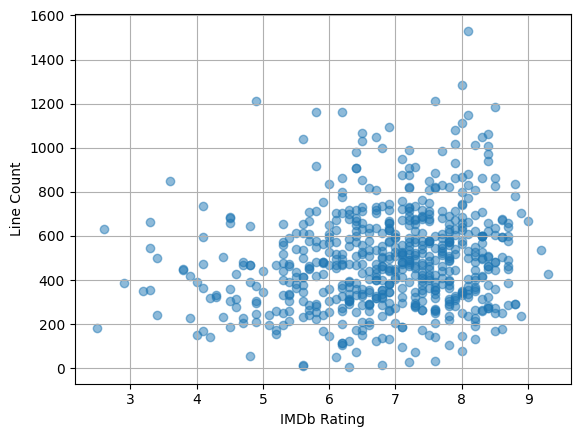

In [9]:
query = """
    SELECT
        m.imdb_rating AS imdb_rating,
        COUNT(l.id) AS line_count
    FROM movie m
    LEFT JOIN line l ON m.id = l.movie_id
    GROUP BY m.id, m.imdb_rating
    ORDER BY imdb_rating;
"""
cursor.execute(query)
results = cursor.fetchall()

imdb_ratings = [result[0] for result in results]
line_counts = [result[1] for result in results]

plt.scatter(imdb_ratings, line_counts,alpha=0.5)
plt.xlabel('IMDb Rating')
plt.ylabel('Line Count')
plt.grid(True)
plt.show()

It could also be interesting to know which genres are the most popular in the dataset. 

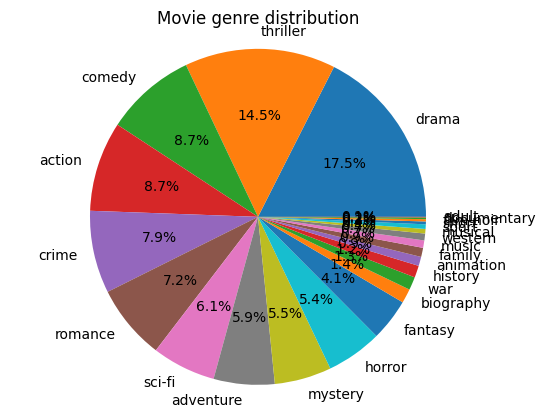

In [11]:
# group by genre_id and count the number of movies in each genre
genre_counts = df_movie_genre['genre_id'].value_counts().reset_index()
genre_counts.columns = ['id', 'movie_count']

# merge with table genre
genre_counts = pd.merge(genre_counts, df_genres, on='id', how='left')

plt.pie(genre_counts['movie_count'], labels=genre_counts['name'], autopct='%1.1f%%')
plt.title('Movie genre distribution')
plt.axis('equal')
plt.show()



Since we have a lot of genres overlapping, we will group them into one genre called 'other' and then plot the results.

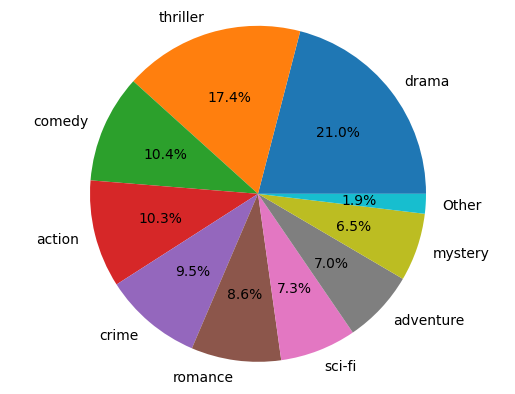

In [28]:
top_genres = genre_counts[genre_counts['movie_count'] >=100]
other_genres_count = genre_counts[genre_counts['movie_count'] <11]['movie_count'].sum()
other_genre_df = pd.DataFrame({'name':['Other'], 'movie_count':[other_genres_count]})
top_genres = pd.concat([top_genres, other_genre_df], ignore_index=True)

plt.pie(top_genres['movie_count'], labels=top_genres['name'], autopct='%1.1f%%')
plt.axis('equal')
plt.show()


Now, it could be interesting to know which words are the most used in the dataset. We will use a wordcloud to visualize this.

In [13]:
from collections import Counter
import nltk
from nltk.tokenize import word_tokenize
import string

#nltk.download('punkt') # uncomment this line if you haven't downloaded punkt before

text_data = ' '.join(df_lines['line_text'].astype(str))
tokens = word_tokenize(text_data)
word_freq = Counter(tokens)
most_common_words = word_freq.most_common(10)
for word,freq in most_common_words:
    print(word, freq)


. 333773
I 140954
? 114486
you 111386
the 88002
to 79245
's 66321
a 66317
n't 55088
... 50740


A lot of stop words.. Let's plot the results again without these...

know 21629
like 14986
get 14132
got 13301
want 11057
think 10773
one 10571
right 10016
go 9900
well 9854
going 8859
would 8286
see 8219
oh 7833
yes 7374
good 7318
could 7241
yeah 6962
tell 6827
come 6749


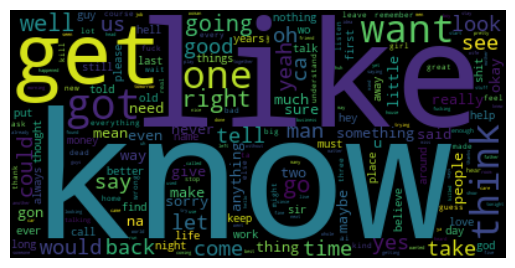

In [31]:
#nltk.download('stopwords') # uncomment this line if you haven't downloaded stopwords before
from wordcloud import WordCloud
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

tokens = [word.lower() for word in tokens if not word.lower() in stop_words and word not in string.punctuation and word.isalpha()]
word_freq = Counter(tokens)
most_common_words = word_freq.most_common(20)
for word,freq in most_common_words:
    print(word, freq)
    
wordcloud = WordCloud().generate_from_frequencies(word_freq)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()
    

Finally, let's see which characters have the most lines of dialogue in the dataset.

In [18]:
query = """
    SELECT
        c.name AS character_name,
        m.title AS movie_title,
        COUNT(l.id) AS line_count
    FROM character c
    JOIN line l ON c.id = l.character_id
    JOIN movie m ON l.movie_id = m.id
    GROUP BY c.name, m.title
    ORDER BY line_count DESC
    LIMIT 10;
"""

cursor.execute(query)
results = cursor.fetchall()
character_names = [result[0] for result in results]
line_counts = [result[1] for result in results]

for row in results:
    character_name, movie_title, line_count = row
    print(f"Character: {character_name}, Movie: {movie_title}, Lines: {line_count}")


Character: DANTE, Movie: clerks., Lines: 537
Character: BEN, Movie: the graduate, Lines: 489
Character: JOE, Movie: innerspace, Lines: 471
Character: ALVY, Movie: annie hall, Lines: 467
Character: ACE, Movie: casino, Lines: 465
Character: ENID, Movie: ghost world, Lines: 441
Character: NIXON, Movie: nixon, Lines: 434
Character: GITTES, Movie: chinatown, Lines: 428
Character: JOHN, Movie: u-turn, Lines: 414
Character: HAROLD, Movie: happy birthday wanda june, Lines: 409


Let's see which actors play the most roles in the dataset.

In [23]:
query = """
    SELECT
        c.name AS actor_name,
        COUNT(DISTINCT cha.id) AS character_count
    FROM actor c
    JOIN character cha ON c.id = cha.actor_id
    GROUP BY actor_name
    ORDER BY character_count DESC
    LIMIT 10; 
"""

cursor.execute(query)
results = cursor.fetchall()
for row in results:
    actor_name, character_count = row
    print(f"Actor: {actor_name}, Characters: {character_count}")



Actor: Nicolas Cage, Characters: 10
Actor: Robert De Niro, Characters: 8
Actor: Johnny Depp, Characters: 8
Actor: Harrison Ford, Characters: 8
Actor: William Shatner, Characters: 7
Actor: Sigourney Weaver, Characters: 7
Actor: Patricia Arquette, Characters: 7
Actor: William H. Macy, Characters: 6
Actor: Philip Baker Hall, Characters: 6
Actor: Dustin Hoffman, Characters: 6


In [26]:
query = """
    SELECT c.name as actor_name,
        COUNT(DISTINCT l.id) AS line_count
    FROM actor c
    JOIN character cha ON c.id = cha.actor_id
    JOIN line l ON cha.id = l.character_id
    GROUP BY actor_name
    ORDER BY line_count DESC
    LIMIT 10;
"""

cursor.execute(query)
results = cursor.fetchall()
for row in results:
    actor_name, line_count = row
    print(f"Actor: {actor_name}, Lines: {line_count}")



Actor: Nicolas Cage, Lines: 1702
Actor: Robert De Niro, Lines: 1546
Actor: Dustin Hoffman, Lines: 1445
Actor: Johnny Depp, Lines: 1402
Actor: William Shatner, Lines: 1020
Actor: Harrison Ford, Lines: 858
Actor: John Cusack, Lines: 787
Actor: Richard Gere, Lines: 553
Actor: Jane Fonda, Lines: 551
Actor: Sigourney Weaver, Lines: 521
